<a href="https://colab.research.google.com/github/dudeh534/Mirae_Exit/blob/main/Stockcastic_Volume_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 구글 드라이브를 마운트한다.
from google.colab import drive

drive.mount('/content/drive')

!ls /content/drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MyDrive


In [23]:
import oracledb
import getpass
#userpwd = getpass.getpass("Enter password: ")

connection=oracledb.connect(
     user="admin",
     password='rlaTPWNS!123',
     dsn="gangnamdatabase_high",
     config_dir="/content/drive/MyDrive/Colab Notebooks",
     wallet_location="/content/drive/MyDrive/Colab Notebooks",
     wallet_password=userpwd)

cursor = connection.cursor()
cursor.execute("select SYSDATE FROM DUAL")
out_data = cursor.fetchone()
print("=====>", out_data[0])


=====> 2023-10-26 15:44:10


In [ ]:
#구글드라이브 연동용
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env 폴더에 패키지 저장
#os.symlink('/content/drive/My Drive/Colab Notebooks/my_env', my_path)
os.symlink('/content/drive/My Drive/Colab Notebooks/my_env', my_path)
sys.path.insert(0, my_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileExistsError: ignored

In [ ]:
# 종목 데이터 csv로 저장

import FinanceDataReader as fdr

df=fdr.DataReader('LCID',"2020-01-01", "2023-08-18")
df.to_csv("TSLA.csv")

Initial Portfolio Value : 10,000,000 KRW
BUY Portfolio Value : 10,000,000 KRW
CLOSE volume : 24
SELL Portfolio Value : 9,636,873 KRW
CLOSE volume : 24
BUY Portfolio Value : 9,899,156 KRW
CLOSE volume : 39
SELL Portfolio Value : 6,767,609 KRW
CLOSE volume : 25
Final Portfolio Value   : 6,773,524 KRW
수익률 : -32.3 %


<IPython.core.display.Javascript object>

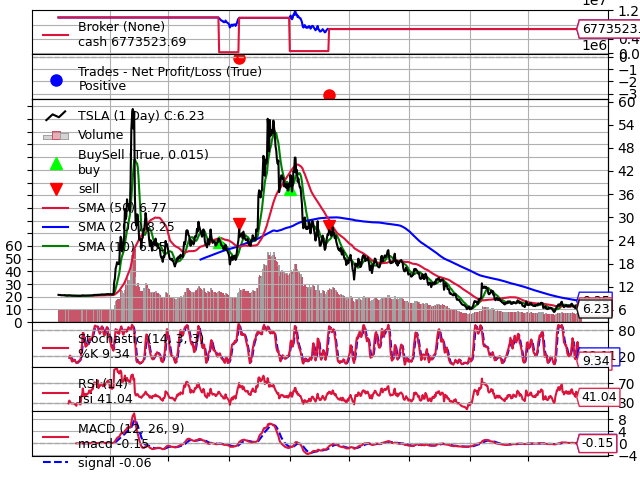

In [ ]:
# 필요한 모듈 임포트
import backtrader as bt
import yfinance as yf
import datetime
import backtrader.feeds as btfeeds
from IPython.display import display, Image

# 백테스팅에 사용할 데이터 불러오기
class customCSV(btfeeds.GenericCSVData):
    params=(
        ('dtformat', '%Y-%m-%d'),
        ('datetime', 0),
        ('time', -1),
        ('open', 1),
        ('high', 2),
        ('low', 3),
        ('close', 4),
        ('volume', 5),
        ('openinterest', -1),
        )

# 백테스팅에 사용할 전략 클래스 정의
class StockcasticStrategy(bt.Strategy):
    # Set the parameters
    params = dict(
        #이용할 지표 설정값들
        stoch_period = 14, # Stochastic Oscillator period
        stoch_upper = 70, # Overbought threshold
        stoch_lower = 30, # Oversold threshold
        rsi_period = 14, # RSI period
        rsi_upper = 70, # Overbought threshold
        rsi_lower = 30, # Oversold threshold
        macd_fast = 12, # MACD short-term moving average period
        macd_slow = 26, # MACD long-term moving average period
        macd_signal = 9, # MACD signal line period
        ma_fast = 50, # Short-term moving average period
        ma_slow = 200, # Long-term moving average period
        #size = 10 # Trading unit (shares)
    )

    def __init__(self):
        # Create indicators

        #stockcastic
        self.stoch = bt.indicators.Stochastic(self.data,
                                              period=self.p.stoch_period,
                                              safediv=True)
        #rsi
        self.rsi = bt.indicators.RSI(self.data,
                                     period=self.p.rsi_period)
        #macd
        self.macd = bt.indicators.MACD(self.data,
                                       period_me1=self.p.macd_fast,
                                       period_me2=self.p.macd_slow,
                                       period_signal=self.p.macd_signal)
        # 골든크로스
        self.ma_fast = bt.indicators.SMA(self.data,
                                         period=self.p.ma_fast)
        self.ma_slow = bt.indicators.SMA(self.data,
                                         period=self.p.ma_slow)
        # 거래량
        self.volume = self.data.volume
        self.volume_ma = bt.indicators.SMA(self.volume, period=10) # 거래량의 10일 이동 평균

    #입맛에 맞게 쓰십셔
    def next(self):
        # Implement trading logic
        if not self.position: # No position
            if (self.stoch[0] < self.p.stoch_lower and # Stochastic oversold
                #self.rsi[0] > 50 or # RSI uptrend confirmation
                #self.macd[0] > self.macd[-1] or # MACD momentum increase
                self.ma_fast[0] > self.ma_slow[0] and # Golden cross
                  (self.data.close[0] > self.data.close[-1] and # 주가가 상승하고
                    self.volume[0]*2 > self.volume[-1] and #전날대비 거래량이 2배 터짐
                    self.volume[0] > self.volume_ma[0])):
                print(f'BUY Portfolio Value : {cerebro.broker.getvalue():,.0f} KRW')
                print(f'CLOSE volume : {data.close[0]:,.0f}')
                self.buy() # Buy
        else: # Have position
            if (self.stoch[0] > self.p.stoch_upper
                and # Stochastic overbought
                #self.rsi[0] < 50 or # RSI downtrend confirmation
                #self.macd[0] < self.macd[-1] or # MACD momentum decrease
                self.ma_fast[0] < self.ma_slow[0]
                #and(self.data.close[0] < self.data.close[-1] and # 주가가 하락하고
                #    self.volume[0] > self.volume_ma[0])
                ): # Death cross
                print(f'SELL Portfolio Value : {cerebro.broker.getvalue():,.0f} KRW')
                print(f'CLOSE volume : {data.close[0]:,.0f}')
                self.close() # Sell



# 백테스팅 엔진 객체 생성
cerebro = bt.Cerebro()

# 데이터 추가
data=customCSV(dataname="TSLA.csv")
cerebro.adddata(data)

# 전략 추가
cerebro.addstrategy(StockcasticStrategy)

# 자본금 설정
cerebro.broker.setcash(10000000)

# 수수료 설정 (0.15%)
cerebro.broker.setcommission(commission=0.0014)

#주 수
cerebro.addsizer(bt.sizers.PercentSizer, percents=95)

print(f'Initial Portfolio Value : {cerebro.broker.getvalue():,.0f} KRW')
KRW_initial = cerebro.broker.getvalue()
cerebro.run()
print(f'Final Portfolio Value   : {cerebro.broker.getvalue():,.0f} KRW')
KRW_final = cerebro.broker.getvalue()
profit_ratio = (KRW_final - KRW_initial) / KRW_initial * 100
print(f'수익률 : {profit_ratio:,.1f} %')

cerebro.plot()[0][0].savefig('plot.png', dpi=100)
display(Image(filename='plot.png'))

In [ ]:
#코드는 다음과 같은 과정을 거쳐 투자 대상 종목을 선택합니다.

#전기차 섹터의 종목을 가져온다.
#종목별 매출 성장률을 계산한다.
#종목별 거래량을 계산한다.
#종목별 stockcastic 지표를 계산한다.
#매출 성장률이 20% 이상이고, 거래량이 50만 주 이상이고, stocastic oscillator가 20% 이상인 경우 매수한다.
#물론, 이 코드는 단순한 예일 뿐입니다. 실제 퀀트 전략을 구현하기 위해서는 보다 다양한 데이터와 분석 기법을 활용해야 합니다.

#이 코드를 개선하기 위해 다음과 같은 방안을 고려할 수 있습니다.

#매출 성장률, 거래량, stocastic oscillator 이외에도 다른 지표를 추가로 고려한다.
#투자 대상 종목의 수를 제한한다.
#투자의 비중을 조절한다.
#백테스트를 통해 전략의 성과를 검증한다.


import pandas as pd
import numpy as np
import yfinance as yf
from stockstats import StockDataFrame

# 전기차 섹터의 종목을 가져온다.
sector = "Technology"
industry = "Electric Vehicles & Energy Storage"
tickers = yf.Tickers(sector + "." + industry)

# 종목별 매출 성장률을 계산한다.
revenue_growth = tickers.info["Revenue Growth (YoY)"]

# 종목별 거래량을 계산한다.
volume = tickers.info["Volume"]

# 종목별 stockcastic 지표를 계산한다.
stocastic_oscillator = StockDataFrame(tickers).stochastic_oscillator()

# 종목별 투자 여부를 판단한다.
def is_buy(ticker):
    # 매출 성장률이 20% 이상이고,
    if revenue_growth[ticker] >= 0.2:
        # 거래량이 50만 주 이상이고,
        if volume[ticker] >= 500000:
            # stocastic oscillator가 20% 이상인 경우 매수한다.
            if stocastic_oscillator[ticker][-1] >= 0.2:
                return True
    return False

# 투자 대상 종목을 선택한다.
buy_list = [ticker for ticker in tickers if is_buy(ticker)]

# 투자 대상 종목의 정보를 출력한다.
for ticker in buy_list:
    print(f"{ticker}의 투자 여부: {is_buy(ticker)}")
    print(f"{ticker}의 매출 성장률: {revenue_growth[ticker]}")
    print(f"{ticker}의 거래량: {volume[ticker]}")
    print(f"{ticker}의 stockcastic oscillator: {stochastic_oscillator[ticker][-1]}")


ModuleNotFoundError: ignored

In [ ]:
pip install cx_Oracle

In [4]:
!pip install --target=$my_path oracledb --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 50.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

# Yahoo Finance에서 정성적 데이터를 가져오는 함수
def get_qualitative_data(ticker):
    # 해당 종목의 웹페이지를 가져온다.
    url = f"https://finance.yahoo.com/quote/{ticker}/profile?p={ticker}"
    res = requests.get(url)
    if res.status_code != 200:
        raise ValueError(f"{ticker}의 웹페이지를 가져올 수 없습니다.")

    # 웹페이지를 BeautifulSoup로 파싱한다.
    soup = BeautifulSoup(res.text, "html.parser")

    # 정성적 데이터를 추출한다.
    qualitative_data = {
        "sector": soup.find("td", {"data-test": "sector"}).text,
        "industry": soup.find("td", {"data-test": "industry"}).text,
        "revenue": soup.find("td", {"data-test": "revenue"}).text,
        "gross_margin": soup.find("td", {"data-test": "gross_margin"}).text,
        "operating_margin": soup.find("td", {"data-test": "operating_margin"}).text,
        "net_income_margin": soup.find("td", {"data-test": "net_income_margin"}).text,
        "pe_ratio": soup.find("td", {"data-test": "pe_ratio"}).text,
        "pb_ratio": soup.find("td", {"data-test": "pb_ratio"}).text,
        "eps_growth_last_5y": soup.find("td", {"data-test": "eps_growth_last_5y"}).text,
        "revenue_growth_last_5y": soup.find("td", {"data-test": "revenue_growth_last_5y"}).text,
    }

    return qualitative_data

# 테스트용 코드
tickers = ["AAPL", "GOOGL", "MSFT"]
qualitative_data = [get_qualitative_data(ticker) for ticker in tickers]

for ticker, data in zip(tickers, qualitative_data):
    print(f"{ticker}의 정성적 데이터: {data}")


NameError: ignored

Initial Portfolio Value : 10,000,000 KRW
[2014-12-16] BUY  : 주가 13, 수량 661,635, 수수료 12,405, 자산 9,851,738
[2015-04-29] SELL : 주가 15, 수량 -661,635, 수수료 14,206, 자산 11,259,607
[2015-10-26] BUY  : 주가 14, 수량 726,982, 수수료 14,342, 자산 11,433,310
[2016-03-10] SELL : 주가 14, 수량 -726,982, 수수료 14,249, 자산 11,164,133
[2016-05-06] BUY  : 주가 14, 수량 712,503, 수수료 14,023, 자산 11,342,961
[2017-01-04] SELL : 주가 14, 수량 -712,503, 수수료 14,281, 자산 11,320,130
[2018-03-28] BUY  : 주가 18, 수량 547,395, 수수료 13,517, 자산 11,058,461
[2019-10-28] SELL : 주가 22, 수량 -547,395, 수수료 16,734, 자산 13,587,479
[2020-03-19] BUY  : 주가 25, 수량 507,810, 수수료 17,759, 자산 15,361,949
[2020-04-20] SELL : 주가 49, 수량 -507,810, 수수료 34,727, 자산 25,654,715
[2021-03-05] BUY  : 주가 209, 수량 111,463, 수수료 32,565, 자산 24,577,739
[2021-10-20] SELL : 주가 288, 수량 -111,463, 수수료 45,012, 자산 34,467,820
[2022-10-12] BUY  : 주가 215, 수량 143,284, 수수료 43,195, 자산 34,698,299
[2023-02-03] SELL : 주가 184, 수량 -143,284, 수수료 36,900, 자산 29,891,465
[2023-05-03] BUY  : 주가 160, 수량 167,814,

<IPython.core.display.Javascript object>

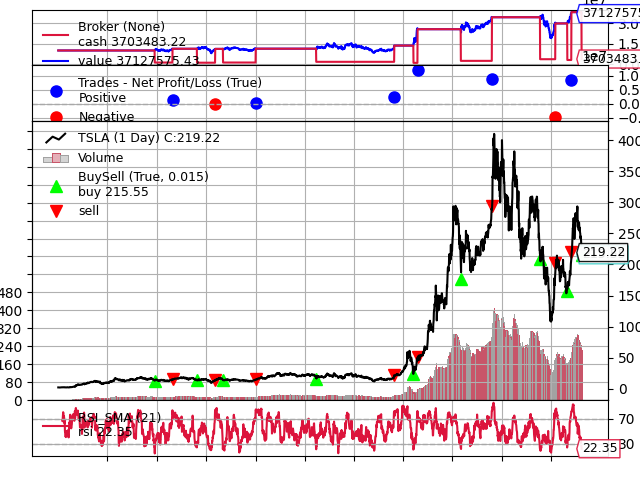

In [ ]:
import backtrader as bt
import yfinance as yf
import datetime
import backtrader.feeds as btfeeds
from IPython.display import display, Image


#https://lunadaddy.tistory.com/114
# Create a subclass of Strategy to define the indicators and logic
class customCSV(btfeeds.GenericCSVData):
    params=(
        ('dtformat', '%Y-%m-%d'),
        ('datetime', 0),
        ('time', -1),
        ('open', 1),
        ('high', 2),
        ('low', 3),
        ('close', 4),
        ('volume', 5),
        ('openinterest', -1),
        )

class MyStrategy(bt.Strategy):
    def __init__(self):
        self.dataclose = self.datas[0].close
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.rsi = bt.indicators.RSI_SMA(self.data.close, period=21)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY  : 주가 {order.executed.price:,.0f}, '
                    f'수량 {order.executed.size:,.0f}, '
                    f'수수료 {order.executed.comm:,.0f}, '
                    f'자산 {cerebro.broker.getvalue():,.0f}')
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log(f'SELL : 주가 {order.executed.price:,.0f}, '
                    f'수량 {order.executed.size:,.0f}, '
                    f'수수료 {order.executed.comm:,.0f}, '
                    f'자산 {cerebro.broker.getvalue():,.0f}')
            self.bar_executed = len(self)
        elif order.status in [order.Canceled]:
            self.log('ORDER CANCELD')
        elif order.status in [order.Margin]:
            self.log('ORDER MARGIN')
        elif order.status in [order.Rejected]:
            self.log('ORDER REJECTED')
        self.order = None

    def next(self):
        if not self.position:
            if self.rsi < 25:
                self.order = self.buy()
        else:
            if self.rsi > 80:
                self.order = self.sell()

    def log(self, txt, dt=None):
        dt = self.datas[0].datetime.date(0)
        print(f'[{dt.isoformat()}] {txt}')

cerebro = bt.Cerebro()
cerebro.addstrategy(MyStrategy)
data=customCSV(dataname="TSLA.csv")

cerebro.adddata(data)
cerebro.broker.setcash(10000000)
cerebro.broker.setcommission(commission=0.0014)
cerebro.addsizer(bt.sizers.PercentSizer, percents=90)

print(f'Initial Portfolio Value : {cerebro.broker.getvalue():,.0f} KRW')
KRW_initial = cerebro.broker.getvalue()
cerebro.run()
print(f'Final Portfolio Value   : {cerebro.broker.getvalue():,.0f} KRW')
KRW_final = cerebro.broker.getvalue()
profit_ratio = (KRW_final - KRW_initial) / KRW_initial * 100
print(f'수익률 : {profit_ratio:,.1f} %')

cerebro.plot()[0][0].savefig('plot.png', dpi=100)
display(Image(filename='plot.png'))